In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

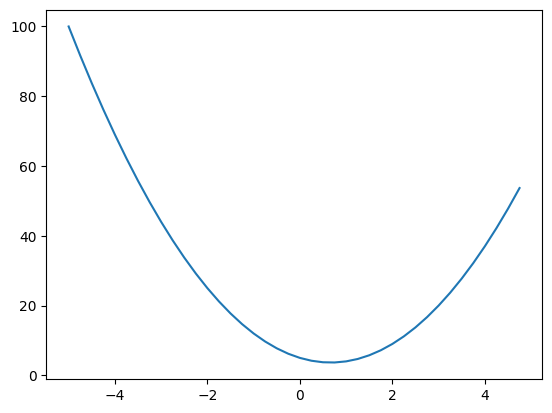

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

[What is the derivative of this function at any x](https://en.wikipedia.org/wiki/Derivative)
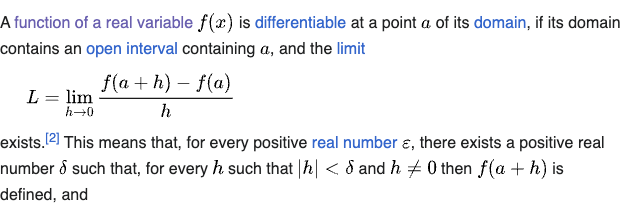

In [4]:
# an example of a small derivative
h = .0001
x = 3.0
x1 = f(x)
x2 = f(x + h)
print(f"x1 = {x1}")
print(f"x2 = {x2}")
# The derivative is how much f(x) changes with respect to h
(x2 - x1 ) / h

x1 = 20.0
x2 = 20.001400030000006


14.000300000063248

In [5]:
# We get a little more complex
a = 2.0
b = -3.0
c = 10
d = a*b + c
d

4.0

In [6]:
h = 0.0001
#inputs
d1 = a * b + c
a += h
d2 = a * b + c # we bump a by h
print('d1',  d1)
print('d2', d2)
print('slope ', (d2 -d1) / h)
# We need to understand the effect of h on a, b or c and how sensitive d is to changes in a, bc,


d1 4.0
d2 3.999699999999999
slope  -3.000000000010772


## Start coding Micrograd

In [75]:
class Value:
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0  # Initialize gradient to zero
        self._prev = set(_children) #linked list functionality empty by default but gets populated when we perform an operation with the class
        self._op = _op
        self.label = label
        self._backward = lambda : None #empty function

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # pointer to the values that caused the op
        #function that propogates the gradient
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self *-1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            #x2.grad = w2.data * x2w2.grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
            return self * other ** -1
            
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other, modulo=None):
        assert isinstance(other, (int, float)), "only support ints and floats"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1) / (math.exp(2*x) +1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
        
            

In [8]:
 a = Value(2, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b  # This already returns a Value object
e.label = 'e'
d = e + c  # This already returns a Value object
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

In [9]:
#notes on derivatives here. L is the product of f and d. So changing f by any amount with change L by f * 4 and  changing d is f * d or -2
def lol():
    a = Value(2, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # This already returns a Value object
    e.label = 'e'
    d = e + c  # This already returns a Value object
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    h = .001
    L = (f + x)



In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [11]:
L.grad = 1.0

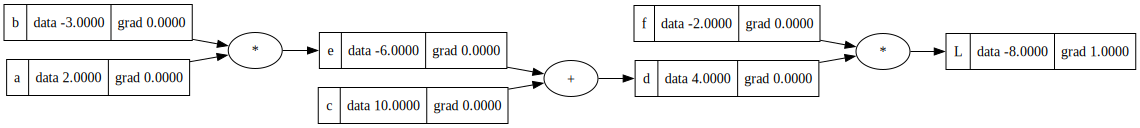

In [12]:
draw_dot(L) # at this point we have the forward pass and the value of L  is 8
#back prop now we need to determine the derivative for the children
# L is our loss function

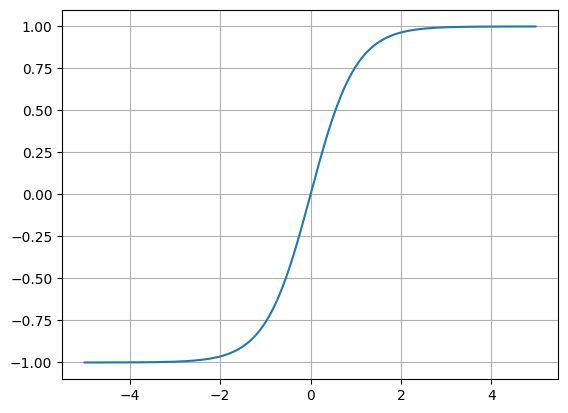

In [13]:
#example of a tanhh function but we could also use sigmoid relu etc
plt.plot(np.arange(-5, 5, .02), np.tanh(np.arange(-5, 5, .02)))
plt.grid()

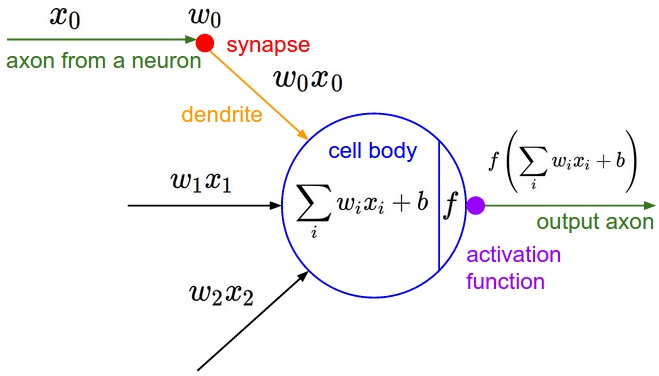

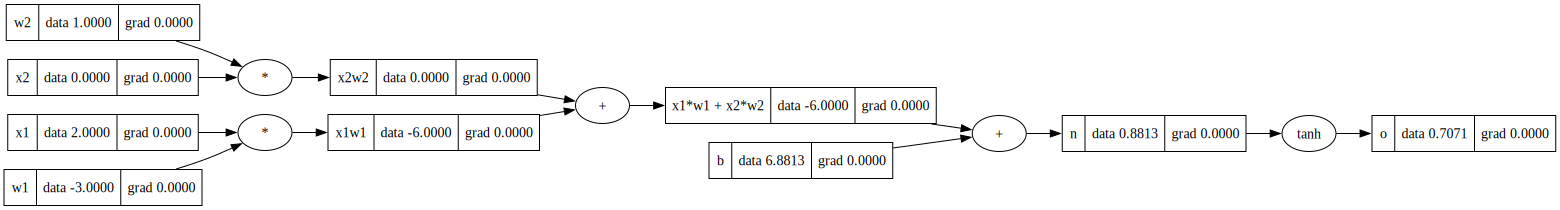

In [14]:
#example neuron with inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88131375870, label='b') #bias of the neuron
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #n is now the cell body
o = n.tanh()
o.label = 'o'
draw_dot(o)

## Implement back propagation
The forward pass though the expression is complete and we have arrived at 0. We have to backwards to get the gradients to see much of a change in x would move o

In [15]:
#o.grad = 1
#o.backward()

### Topo Sort and Back Prop
Note that the final impl has the backwards function  moved into the Value class. I left it explicit here as well for clarity

In [16]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) #only added to list once all children are added

build_topo(o)
topo
o.grad =1
for node in reversed(topo):
    node._backward()


Below is the second impl of back prop. We have implemented the backwards function and call it in order.

In [17]:
#o.grad = 1
#o._backward()
#n._backward()
#b._backward()
#x1w1x2w2._backward()
#x2w2._backward()
#x1w1._backward()

The Code below is a manual implementation of back prop with out a backwards function in the Value object. This is the first impl in the course

In [18]:
#x2.grad = w2.data * x2w2.grad
#w2.grad = x2.data * x2w2.grad
#x1.grad = w1.data * x1w1.grad
#w1.grad = x1.data * x1w1.grad
#chain rule

In [19]:
#x1w1.grad = .5
#x2w2.grad = .5

In [20]:
#x1w1x2w2.grad = .5
#b.grad = .5

In [21]:
#n.grad = .5

In [22]:
#back prop
#o.grad = 1.0 #o with respect to itself is always 1 our base case


In [23]:
#1 - o.data ** 2
#next node is a plus so it would just distribute the gradient to the children


In [24]:
# o = tanh(n)
# do/dn = 1 - o**2 derivative of o with respect to n

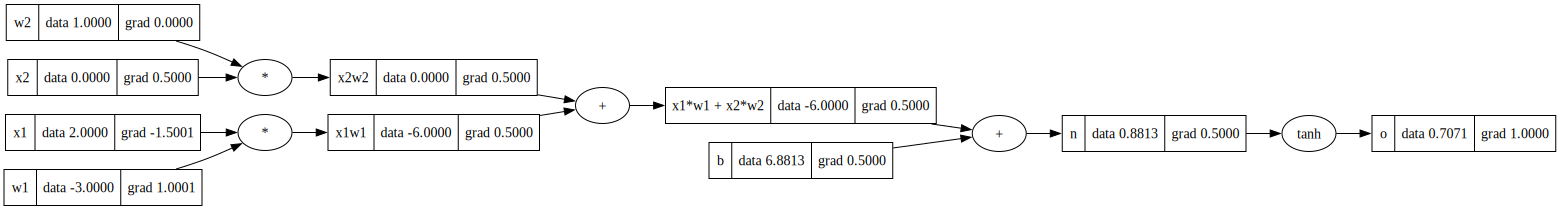

In [25]:
draw_dot(o)

## Neural Net
Multi Layer Perceptron

In [94]:
import random
class Neuron:
    def __init__(self, nin):
        """
        :param nin: number of inputs
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] #create our weights
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
       """
       getting the dot product our forward pass through the w and x vectors
       :param self:
       :param x:
       :return:
       """
       act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
       out = act.tanh() #these activation functions solve the xor problem
       return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
     def __init__(self, nin, nout):
         self.neurons = [Neuron(nin) for _ in range(nout)]

     def __call__(self, x):
          outs = [n(x) for n in self.neurons]
          return outs[0] if len(outs) == 1 else outs

     def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## Simple example of 1 neuron with 2 inputs. We see the inputs being mutliplied the weight and and then passed to the activation function tanh()

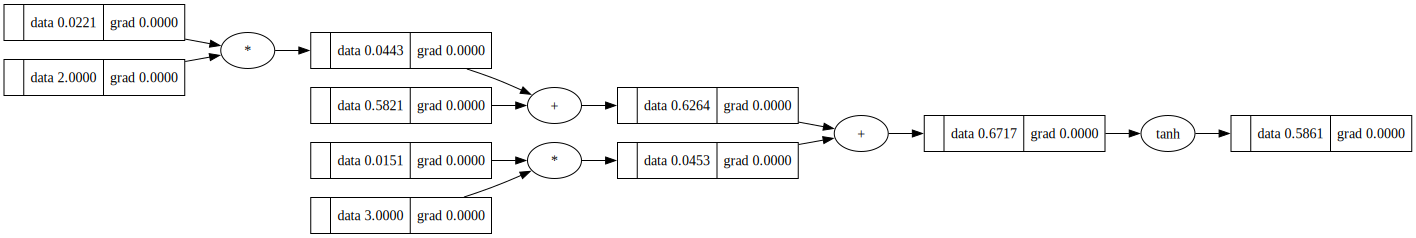

In [95]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)
draw_dot(n(x))


## Layers
A container for a group of neurons

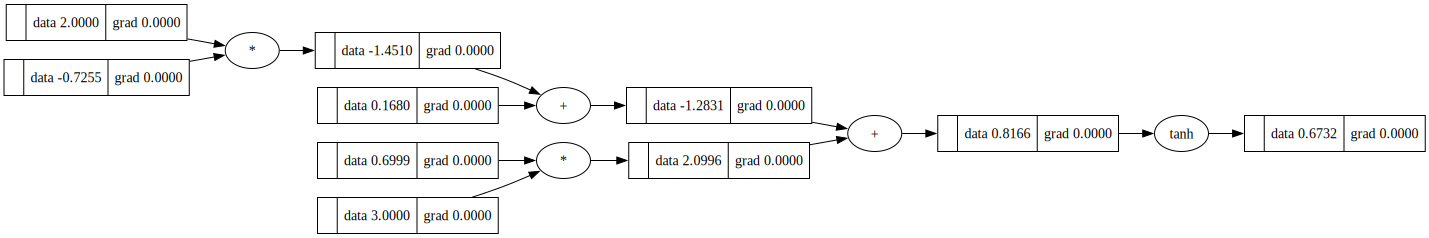

In [96]:
n = Layer(2,3)
draw_dot(n(x)[0])

## MLP
n = MLP(2,2)

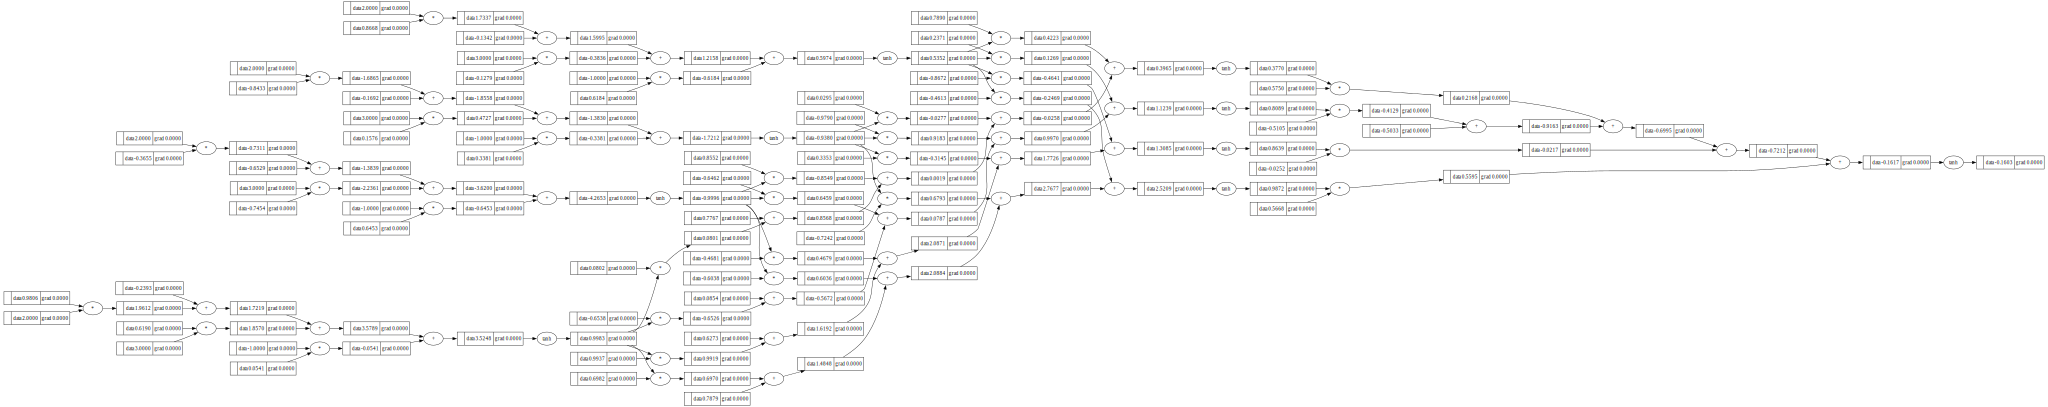

In [97]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
draw_dot(n(x))

In [98]:
#small data set simple binary classifier ys are 1 or -1
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

y_preds = [n(x) for x in xs]
y_preds

[Value(data=-0.160299907768304),
 Value(data=0.09510185611323958),
 Value(data=0.1807571873695573),
 Value(data=-0.3502255903020141)]

## Tune MLP

In [99]:
# loss function
loss = sum([(yout - ygt) **2 for ygt, yout in zip(ys, y_preds)])
loss


Value(data=5.762840631461088)

In [100]:
loss.backward() # get them gradients
n.layers[0].neurons[0].w[0].grad

0.14486813233103568

In [118]:
#final tune of the NN. We can see the loss function trending to 0
for k in range(40):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.5 * p.grad ## learning rate * gradient

  print(k, loss.data)

0 0.00041083739644463325
1 0.0004077793628231248
2 0.00040476560550052815
3 0.0004017951751512516
4 0.0003988671493373627
5 0.00039598063156428935
6 0.00039313475037605226
7 0.0003903286584880569
8 0.00038756153195563365
9 0.00038483256937671395
10 0.0003821409911269172
11 0.00037948603862553106
12 0.00037686697363103827
13 0.00037428307756465305
14 0.0003717336508607449
15 0.00036921801234276607
16 0.0003667354986236469
17 0.0003642854635294221
18 0.00036186727754515026
19 0.00035948032728212693
20 0.0003571240149652781
21 0.000354797757940118
22 0.00035250098819816853
23 0.000350233151920167
24 0.0003479937090362363
25 0.0003457821328023238
26 0.00034359790939218624
27 0.0003414405375042648
28 0.0003393095279828204
29 0.00033720440345270513
30 0.00033512469796731124
31 0.00033306995666893924
32 0.00033103973546130816
33 0.000329033600693517
34 0.0003270511288551431
35 0.0003250919062818771
36 0.00032315552887142164
37 0.00032124160180908666
38 0.000319349739302845
39 0.00031747956432

In [119]:
ypred

[Value(data=0.9912098963557274),
 Value(data=-0.9921628765801523),
 Value(data=-0.9916112624666),
 Value(data=0.9895874008360973)]